## b988 - 20/10/2016 - VANAHEIM - Trapped Lee Wave

During this flight the FAAM aircraft was flying downwind of the Snaefellsnes Peninsula on the West Coast of Iceland. The aircraft data are compared with WRF model results. The variable that is compared is the vertical wind speed. We compare the data for a set of runs when the aircraft was flying at ~750mb altitude.

In [1]:
%matplotlib inline

import os

ROOT_DATA_PATH = '/Users/watson-parris/Desktop/cis_workshop/data/b988'

os.chdir(ROOT_DATA_PATH)

The WRF vertical wind speed variable has been extracted and converted into netCDF.

In [2]:
import cis 

# Read in the wrf model data set
wrf = cis.read_data('b988_wrf_w_750mb.nc', 'w')
# Fix the coordinate name
wrf.coord('times').rename('time')
print(wrf)

w / (1)                             (latitude: 300; longitude: 320; times: 119)
     Dimension coordinates:
          latitude                           x               -           -
          longitude                          -               x           -
          times                              -               -           x


/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/iris/analysis/cartography.py:376: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/numpy/ma/core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)
/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(63.5, 68.0)

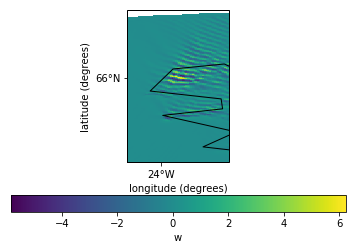

In [4]:
# Average over all timestamps. The waves were stationary for the whole run
wrf_avg = wrf.collapsed('time', how='mean')
ax = wrf_avg.plot()
# Zoom into the area of interest
ax.set_xlim((-25, -22))
ax.set_ylim((63.5, 68.0))

### Preparing the aircraft data

For this example we like to work with the high resolution data and not just the 1Hz data. To do that we need to get rid off the sps dimensions of the FAAM core netCDF and flatten it, so that the only remaining dimension is Time. We use a combination of pandas and xarray to create a new netCDF.

In [5]:
import cis
import pandas as pd
import numpy as np
from cis.utils import demote_warnings

OVERWRITE_NETCDF = False

# List of variables that we gonna to extract from the high
# resolution FAAM core netCDF. All those variables are available at 32Hz
var_names = ['LON_GIN',
             'LAT_GIN',
             'ALT_GIN',
             'W_C',
             'PS_RVSM']

# Open the FAAM core netCDF. CIS will read this as gridded data using Iris by default
# Iris is really slow at reading this, so we might be better off just using NetCDF directly?
with demote_warnings():
    core = cis.read_data_list('core_faam_20161020_v004_r0_b988.nc', var_names)

In [6]:
print(core)

GriddedDataList: 
0: LON_GIN / (degrees)                 (time: 14977; -- : 32)
1: LAT_GIN / (degrees)                 (time: 14977; -- : 32)
2: ALT_GIN / (m)                       (time: 14977; -- : 32)
3: W_C / (m s-1)                       (time: 14977; -- : 32)
4: PS_RVSM / (hPa)                     (time: 14977; -- : 32)


Now use Pandas to create the time points

In [7]:
from cf_units import Unit
from cis.time_util import cis_standard_time_unit

# This are the units for the time coordinate
time_units = Unit("seconds since 2016-10-20 00:00:00 +0000")

# Now the panda magic begins.
# Creating a high resolution time array using panda magic
# The time step is 1./32. seconds, which equals 31250 microseconds.
t2 = pd.date_range(start=cis_standard_time_unit.num2date(core.coord('time').points.min()),
                   periods=core.coord('time').shape[0]*32,
                   freq='31250U').to_pydatetime()

# Convert it back to seconds after midnight using the date2num method from netCDF4
secs = time_units.date2num(t2)

And convert the data into CIS UngriddedData objects

In [9]:
import cis
from cis.data_io.ungridded_data import UngriddedData, UngriddedDataList, Metadata
from cis.data_io.Coord import Coord

OVERWRITE_NETCDF = True

lon = Coord(core[0].data.ravel(), Metadata('longitude', units='degree_east'), 'x')
lat = Coord(core[1].data.ravel(), Metadata('latitude', units='degree_north'), 'y')
alt = Coord(core[2].data.ravel(), Metadata('altitude', units='m'), 'z')
pres = Coord(core[4].data.ravel(), Metadata('air_pressure', units='hPa'), 'p')
time = Coord(secs, Metadata('time', units=time_units))

w_c = UngriddedData(core[3].data.ravel(), 
                        Metadata('w_c', units='m s-1'), 
                        [lat, lon, pres, alt, time])

# flag all data '0' ALT_GIN data as invalid
w_c.data.mask |= alt.data == 0.0

### Analysis

Now that we made it that far we can load the newly created netCDF with cis.

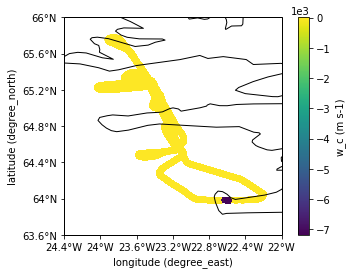

In [10]:
w_c.plot()

In [11]:
# There are some errorenous data in the data set, which screws up the data range
w_c.data.mask[np.abs(w_c.data) > 10] = True

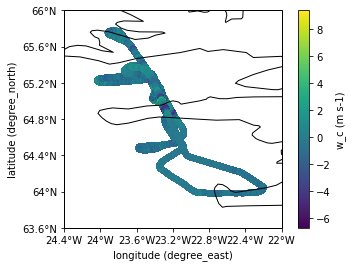

In [12]:
w_c.plot()

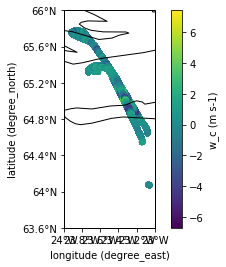

In [13]:
# Subsetting the data for a specific height range, which equals roughly 
# the 750mb level from the WRF model
w_c_sub = w_c.subset(z=[2280, 2360])
w_c_sub.plot()

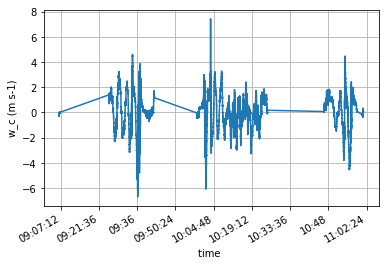

In [14]:
# And plot it as a time series to see wave structure in the vertical
# wind component
ax = w_c_sub.plot(xaxis='time')
ax.grid(True)

In [15]:
# TODO: collocating with wrf and comparing model with aircraft measurements
wrf_col = wrf.collocated_onto(w_c_sub)

/Users/watson-parris/anaconda/envs/cis_env3/lib/python3.5/site-packages/cis/collocation/gridded_interpolation.py:181: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  expanded_result[~self.missing_mask] = result


In [16]:
wrf_col.append(w_c_sub)

(736258.3923611111, 736258.4027777778)

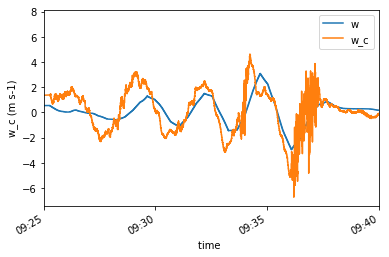

In [17]:
from datetime import datetime
ax = wrf_col.plot(xaxis='time')

# I have no idea why this has to be the 21st!
ax.set_xlim([datetime(2016,10,21,9,25), datetime(2016,10,21,9,40)])